<a href="https://colab.research.google.com/github/SanyamSwami123/make-more-series-andrej-karpathy/blob/main/3_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MLP**: Multilayer perceptron, character level language model.

Prediction from bigram model is not very good because it takes one character of the context, that is why we are going with **MLP**

Here we see:
1. model training
2. learning rate tuninig
3. hyperparameters
4. evaluation
5. triain/dev/test splits
6. under/overfitting.

MLP, [Paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).

- In MLP, we are taking 3 previous words, trying to predict the next word(i.e. 4th word) in the sequence.

# lets Start coding

In [158]:
import random

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [159]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [160]:
len(words)

32033

In [161]:
# build the vocabulary of characters and mapping to/from integers
Chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(Chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [162]:
# build dataset
def build_dataset(words):
  block_size = 3 # context length: how many characters do we take to predict the next one?
  X, Y = [], []
  for w in words:

    # print(w)
    context  = [0] * block_size # padded context of 0 tokens
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X,Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [163]:

Xtr.shape, Xdev.shape, Xte.shape, Ytr.shape, Ydev.shape, Yte.shape

(torch.Size([182625, 3]),
 torch.Size([22655, 3]),
 torch.Size([22866, 3]),
 torch.Size([182625]),
 torch.Size([22655]),
 torch.Size([22866]))

In [165]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)# lookup table so each one of 27 chars we have 10 dimensions
W1 = torch.randn((30, 200), generator=g) # we are passing this layer (3,10) thus input will  be 30 note: ( , ) here 1st dimension ie first place always takes input and 2nd place takes the no. neuron
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator= g) #final layer softmax
b2 = torch.randn(27, generator= g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [155]:
sum(p.nelement() for p in parameters) # number of parameter in total

11897

In [170]:
# training loop
lossi = []
stepi = []
for _ in  range(200000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # [32,3,2] emb.shape # 3 inputs with 27 character each located at 2 dimensions
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # [32,100] view is more efficient way then torch.cat(torch.unbind(emb, 1), 1)# resource:https://pytorch.org/docs/stable/generated/torch.unbind.html, as it does not store any storage
  logits = h @ W2 + b2 # [32,27]
  loss = F.cross_entropy(logits, Ytr[ix]) #classification efficient loss function always use this one for Class.

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  #step/update the params
  lr= 0.1 if _<100000 else 0.01 # learning rate decay
  for p in parameters:
    p.data += -lr * p.grad # find good lre you will find different and more good ways online

  stepi.append(_)
  lossi.append(loss.log10().item())
# print(loss.item())

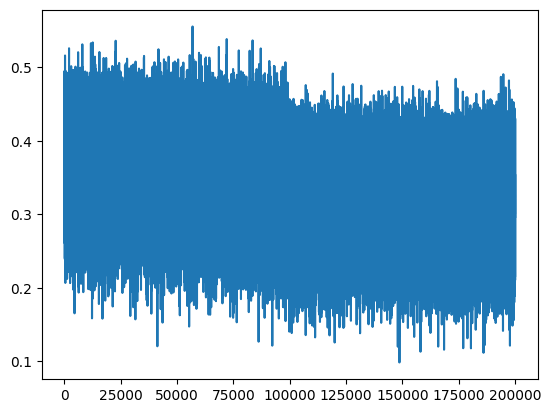

In [171]:
plt.plot(stepi, lossi)
plt.show()

In [172]:
emb = C[Xtr] # [32,3,2] emb.shape # 3 inputs with 27 character each located at 2 dimensions
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # [32,100] view is more efficient way then torch.cat(torch.unbind(emb, 1), 1)# resource:https://pytorch.org/docs/stable/generated/torch.unbind.html, as it does not store any storage
logits = h @ W2 + b2 # [32,27]
loss = F.cross_entropy(logits, Ytr) #classification efficient loss function always use this one for Class.
print(loss.item())

2.0887985229492188


In [173]:
emb = C[Xdev] # [32,3,2] emb.shape # 3 inputs with 27 character each located at 2 dimensions
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # [32,100] view is more efficient way then torch.cat(torch.unbind(emb, 1), 1)# resource:https://pytorch.org/docs/stable/generated/torch.unbind.html, as it does not store any storage
logits = h @ W2 + b2 # [32,27]
loss = F.cross_entropy(logits, Ydev) #classification efficient loss function always use this one for Class.
print(loss.item())

2.1453044414520264


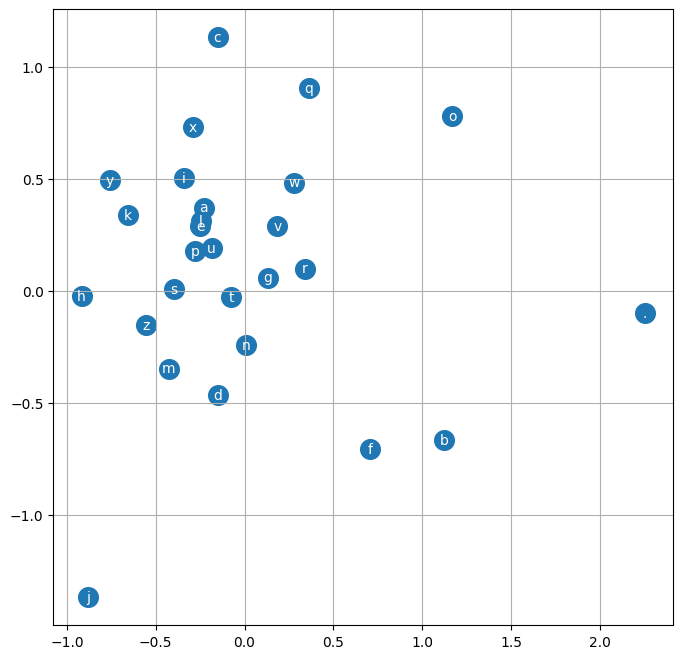

In [174]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(27):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [77]:
# training (use for  learining param/optimization), dev (use for hyperparameter optimization parameter), test splits (use for output/inference checking purpose).
# 80%, 10%, 10%

tensor(17.7697, grad_fn=<NllLossBackward0>)

In [176]:
# sample/inference from the model
block_size = 3 # context length: how many characters do we take to predict the next one?
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0] * block_size # initialize with all
  while True:
    # forward pass
    emb = C[torch.tensor([context])] # (1,block_size,d)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out)) # decode and print the generated word

montalmyah.
seel.
nihaham.
remman.
emdrie.
razeeko.
eliah.
mikoealeigh.
samanareelyziah.
kamin.
shubergani.
jest.
jaireelynn.
noelofio.
zayven.
kylene.
eli.
kayshaykeyah.
hal.
samyah.
